## Employee Retention

### Business Problem
Employee churn is the overall turnover in an organization's staff as existing employees leave and new ones are hired. The churn rate is usually calculated as the percentage of employees leaving the company over some specified time period. Although some staff turnover is inevitable, a high rate of churn is costly.

### Roadmap
1. Understand when and why employees are most likely to leave (people analytics)
2. Create a table with date, employee_headcount (# employed on that specific day), company_id
3. Build a model to predict employee retention
4. Derive main driving factors for employee churn
5. Consider potential additional variables that can aid in predicting employee retention.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
%matplotlib inline

### Load Data

Dataset:<br>
Retention: There are 24,702 employee records. If quit date is null then employee hasn't churned yet.


In [7]:
df = pd.read_csv('retention.csv',parse_dates = ['join_date','quit_date'])

In [8]:
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [9]:
df.shape

(24702, 7)

In [10]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   employee_id  24702 non-null  float64       
 1   company_id   24702 non-null  int64         
 2   dept         24702 non-null  object        
 3   seniority    24702 non-null  int64         
 4   salary       24702 non-null  float64       
 5   join_date    24702 non-null  datetime64[ns]
 6   quit_date    13510 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 1.3+ MB


In [80]:
len(df.employee_id.unique())

24702

In [11]:
df.describe() 

,employee_id,company_id,seniority,salary
count,24702.000000,24702.000000,24702.000000,24702.000000
mean,501604.403530,3.426969,14.127803,138183.345478
std,288909.026101,2.700011,8.089520,76058.184573
min,36.000000,1.000000,1.000000,17000.000000
25%,250133.750000,1.000000,7.000000,79000.000000
50%,500793.000000,2.000000,14.000000,123000.000000
75%,753137.250000,5.000000,21.000000,187000.000000
max,999969.000000,12.000000,99.000000,408000.000000


#### Outlier Analysis

We can see from the above table that seniority has an outlier of 99. We will investigate this further.

In [12]:
df[df.seniority>50]

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
24700,97289.0,10,engineer,98,266000.0,2011-12-13,2015-01-09
24701,604052.0,1,marketing,99,185000.0,2011-07-26,2013-12-06


Since, there are just 2 records with seniority value above 50, we will drop them.

In [13]:
df = df.drop([24700,24701])

In [14]:
df.sort_values(by='salary',ascending = False)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
10689,62540.0,2,engineer,23,408000.0,2013-08-26,NaT
7919,517439.0,2,engineer,25,406000.0,2013-09-16,NaT
3172,965750.0,1,data_science,19,398000.0,2015-05-04,NaT
4150,707585.0,1,engineer,22,393000.0,2013-09-16,NaT
6638,460908.0,1,engineer,24,386000.0,2014-11-03,NaT
...,...,...,...,...,...,...,...
21609,376421.0,4,customer_service,3,18000.0,2012-08-13,2013-08-16
17954,783128.0,3,customer_service,1,18000.0,2014-01-06,NaT
16559,113885.0,4,customer_service,2,18000.0,2014-02-10,NaT
4107,813428.0,8,customer_service,1,17000.0,2011-10-31,2012-10-12


In [27]:
emp_quit = df[~df['quit_date'].isna()]

print('Total Number of Employees:{}\nTotal number of employees churned:{}\nChurn Rate:{:.2f}%'.format(len(df),len(emp_quit),(len(emp_quit)/len(df))*100))

Total Number of Employees:24700
Total number of employees churned:13508
Churn Rate:54.69%


### Feature Engineering

Churn: If quit date is null then 0 else 1<br>
Working days: How many days was the employee employed for, before they quit.

In [35]:
df['churn'] = 1
df.loc[df.quit_date.isnull(),'churn']=0
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,churn
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,1
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,1
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,0
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,1
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1


In [36]:
end_date = '2015-12-13'
df['days_employed'] = (df.quit_date - df.join_date).dt.days
df.loc[df.quit_date.isnull(),'days_employed'] = (pd.to_datetime(end_date) - df.join_date).dt.days
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,churn,days_employed
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,1,585.0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,1,340.0
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,0,426.0
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,1,389.0
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1,1040.0


### Create a table with date, employee_headcount (# employed on that specific day), company_id

In [28]:
start = min(df.join_date)

In [29]:
unique_date = pd.date_range(start = '2011-01-24',end = '2015-12-13',freq = 'D')
unique_company = sorted(df.company_id.unique())
date = []
company = []
headcount = []
for dt in unique_date:
    for comp in unique_company:
        total_join = len(df[(df.join_date <= dt) & (df.company_id == comp)])
        total_quit = len(df[(df.quit_date <= dt) & (df.company_id == comp)])
        head = total_join - total_quit
        date.append(dt)
        company.append(comp)
        headcount.append(head)
        

In [30]:
table = pd.DataFrame({'date':date,'employee_headcount':headcount,'company':company},columns = ['date','employee_headcount','company']
                    )
table.head()

,date,employee_headcount,company
0,2011-01-24,25,1
1,2011-01-24,17,2
2,2011-01-24,9,3
3,2011-01-24,12,4
4,2011-01-24,5,5


### Exploratory Analysis

#### Churn by department

In [32]:
#churn by dept
grp_dept = emp_quit.groupby('dept').size().to_frame('size').reset_index()
grp_dept = grp_dept.sort_values(by='size',ascending=False)
grp_dept

,dept,size
0,customer_service,5094
3,engineer,2361
5,sales,1811
4,marketing,1782
1,data_science,1682
2,design,778


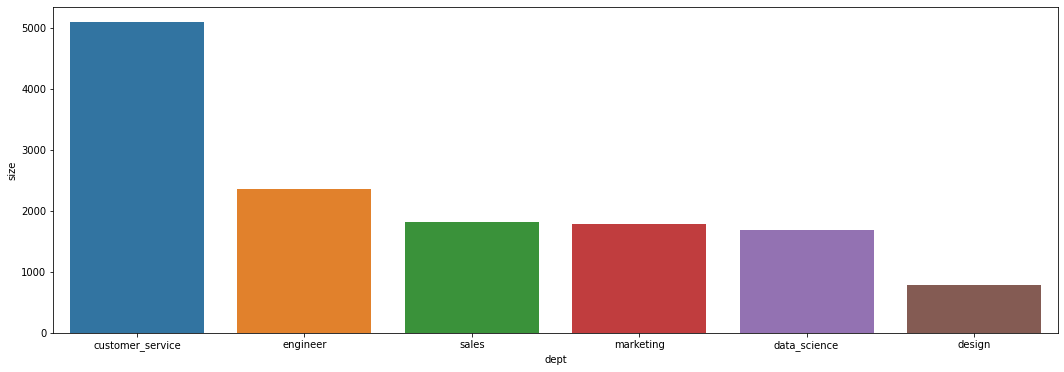

In [33]:
fig,ax= plt.subplots(figsize=(18,6))
sns.barplot(x='dept',y='size',data=grp_dept,ax=ax)
plt.show()

#### Results
Customer Service has the highest number of employees who churned.

#### Churn by working days

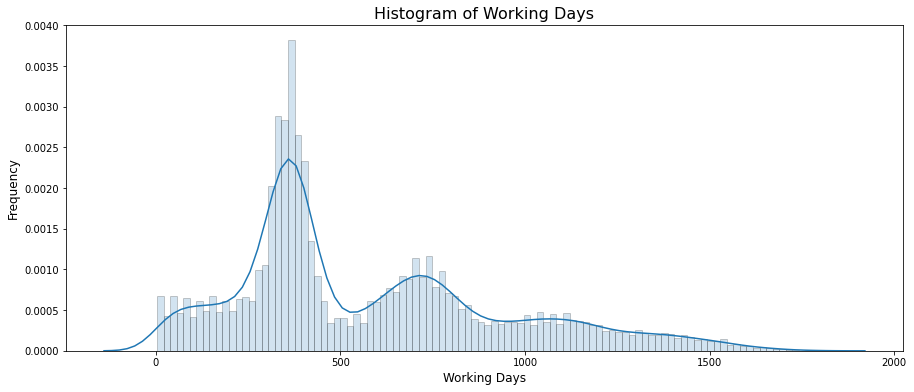

In [37]:
#working days
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
fig, ax = plt.subplots(figsize=(15, 6))
sns.distplot(df['days_employed'], bins=100,ax=ax, hist_kws=hist_kws)
ax.set_title('Histogram of Working Days', fontsize=16)
ax.set_xlabel('Working Days', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.show()

#### Results

A large number of employees churn within 1-2 years

#### Churn by year, month

In [40]:
emp_quit['month_year'] = pd.to_datetime(emp_quit['quit_date']).dt.to_period('M')

<ipython-input-40-c4a2c24f9593>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emp_quit['month_year'] = pd.to_datetime(emp_quit['quit_date']).dt.to_period('M')


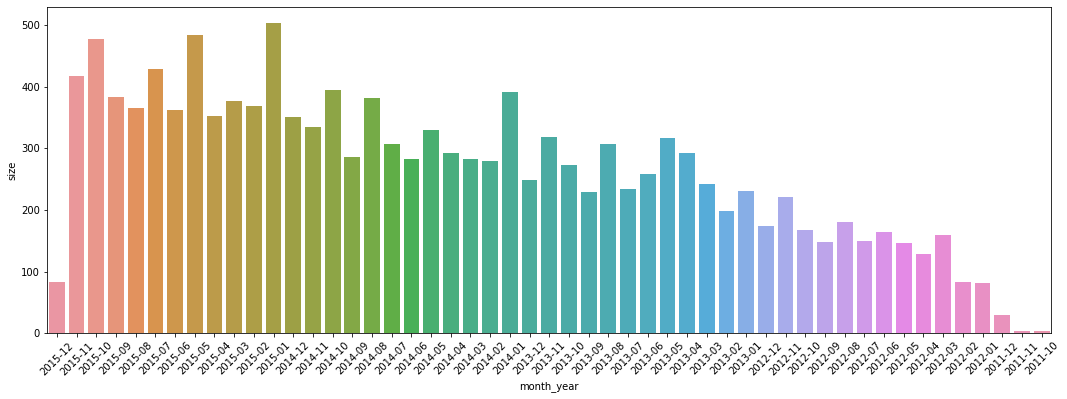

In [41]:
grp_monyear = emp_quit.groupby('month_year').size().to_frame('size').reset_index()
grp_monyear = grp_monyear.sort_values(by='month_year',ascending=False)

fig,ax= plt.subplots(figsize=(18,6))
mon = sns.barplot(x='month_year',y='size',data=grp_monyear,ax=ax)
mon.set_xticklabels(mon.get_xticklabels(),rotation=45)
plt.show()

#### Results
A lot of churn is happening recently in 2015. Maybe a lot of employees joined in 2012-2013 who are now churning.

#### Churn by seniority and salary

In [42]:
# Define a list of numerical columns
NUMERICAL = ['seniority', 'salary', 'days_employed']

# Define a list of categorical variables
CATEGORICAL = ['company_id', 'dept']

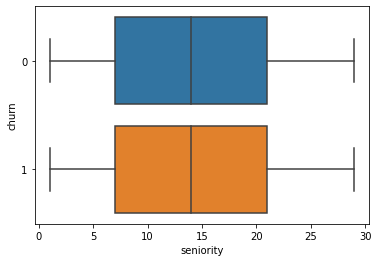

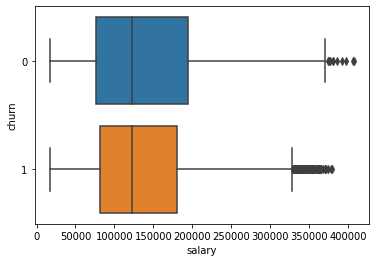

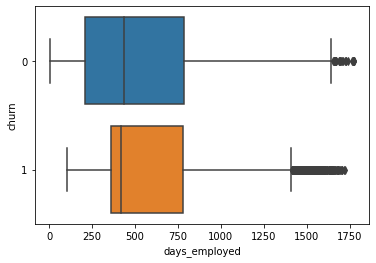

In [43]:
# Use boxplots to visualize the distribution of the data
for col in NUMERICAL:
    sns.boxplot(x=col, y='churn', data=df, orient='h')
    plt.show()

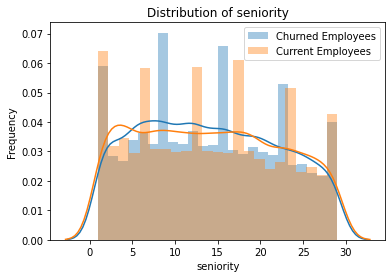

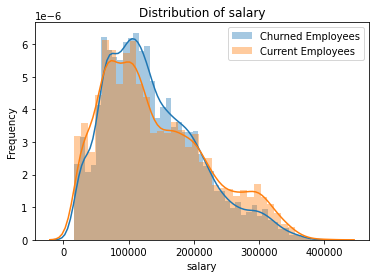

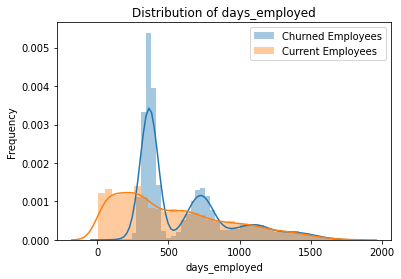

In [44]:
for col in NUMERICAL:
    # Plot the samples
    sns.distplot(df[df.churn==1][col], label='Churned Employees')
    sns.distplot(df[df.churn==0][col], label='Current Employees')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title('Distribution of {}'.format(col))
    plt.legend()
    plt.show()

#### Results

1. Employees who were retained tend to have a higher salary than the ones who churned
2. Seniority of those who churned is same as the ones who are retained
3. Number of working days is less for employees for churn

#### Average churn by company


Company 11 has the highest attrition rate

In [47]:
# Calculate the churn rate for each company
company_df = df.groupby('company_id').agg({'churn':'mean','employee_id':'size'})
company_df

,churn,employee_id
company_id,,
1,0.544490,8485
2,0.522501,4222
3,0.556930,2749
4,0.559166,2062
5,0.560114,1755
6,0.551510,1291
7,0.565359,1224
8,0.553009,1047
9,0.550468,961


Which department in company 11 has the highest churn rate?

In [53]:
company_dep = df[df.company_id == 11].groupby('dept').agg({'churn':'mean','employee_id':'size'})
company_dep

,churn,employee_id
dept,,
customer_service,0.500000,6
data_science,1.000000,2
engineer,0.833333,6
marketing,1.000000,2


In [52]:
company_dept = df.groupby(['company_id', 'dept', 'churn']).agg({'seniority':'mean', 'salary':'mean', 'days_employed':'mean'})
company_dept.loc[11]

seniority         salary  days_employed
dept             churn                                         
customer_service 0      14.666667   58333.333333     677.666667
                 1       5.666667   27333.333333     367.666667
data_science     1      16.500000  153500.000000     693.000000
engineer         0       2.000000   45000.000000    1217.000000
                 1      17.600000  179000.000000     485.800000
marketing        1      23.000000  124500.000000     843.500000

Customer Service has highest churn rate in company 11 and it is driven by lower salaries of those who churned.

#### BootStrapping with 95% Confidence Interval

We will use bootstrapping to confirm the difference in the salaries and working days to who churns.

In [54]:

# Define a function for bootstrapping
def bootstrap(cat, num):
    '''Returns [num] bootstrap means of specified category'''
    # Create [num] instances of empty arrays for low_train, high_train to contain the bootstrap samples
    old_employ_bootstrap = np.empty(num)
    current_employ_bootstrap = np.empty(num)

    for i in range(num):
        # Define the bootstrap samples and store them in the empty arrays 
        old_employ_bootstrap[i] = np.mean(np.random.choice(df[df.churn==1][cat], len(df[df.churn==1])))
        current_employ_bootstrap[i] = np.mean(np.random.choice(df[df.churn==0][cat], len(df[df.churn==0])))
        
    return old_employ_bootstrap, current_employ_bootstrap


seniority:
95% Confidence Interval for Churned Employees: [13.98698549 14.25188407]
95% Confidence interval for Current Employees: [13.99664492 14.29250804]


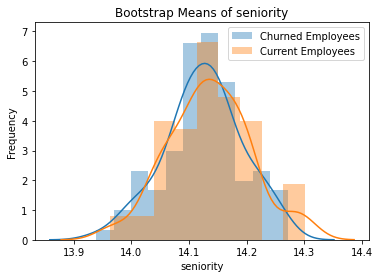


salary:
95% Confidence Interval for Churned Employees: [134701.42878294 136729.27339354]
95% Confidence interval for Current Employees: [139813.71291994 142541.50509292]


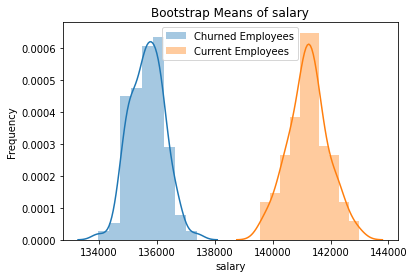


days_employed:
95% Confidence Interval for Churned Employees: [608.44394433 618.21210024]
95% Confidence interval for Current Employees: [520.51914761 533.57266128]


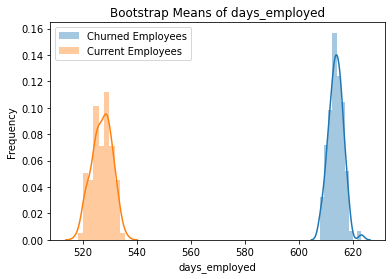

In [55]:
for col in NUMERICAL:
    
    # Define 100 bootstrap samples for each category
    old_repl, current_repl = bootstrap(col, 100)
    
    # Define the confidence intervals
    confidence_interval_old = np.percentile(old_repl, [2.5, 97.5])
    confidence_interval_current = np.percentile(current_repl, [2.5, 97.5])
    
    # Print the results
    print ('\n{}:'.format(col))
    print ('95% Confidence Interval for Churned Employees:', confidence_interval_old)
    print ('95% Confidence interval for Current Employees:', confidence_interval_current)
    
    # Plot the samples
    sns.distplot(old_repl, label='Churned Employees')
    sns.distplot(current_repl, label='Current Employees')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title('Bootstrap Means of {}'.format(col))
    plt.legend()
    plt.show()

We were able to confirm that the salaries of employees who churned is way lower than the employees who are retained

### Churn Prediction

We will use Random Forest Classfier to predict if an employee will churn or not.

In [149]:
df.columns

Index(['employee_id', 'company_id', 'dept', 'seniority', 'salary', 'join_date',
       'quit_date', 'days_employed', 'churn', 'year', 'month_year'],
      dtype='object')

Label Encode Department

In [57]:
le= LabelEncoder()
df1 = df.copy()
df1['dept'] = le.fit_transform(df1['dept'])
le.classes_

array(['customer_service', 'data_science', 'design', 'engineer',
       'marketing', 'sales'], dtype=object)

In [62]:
Y = df1['churn']
x = df1[['company_id','dept','seniority','days_employed','salary']]


# Split the test and training data
X_train, X_test, y_train, y_test = train_test_split(x, Y, test_size=0.3, random_state=123)

In [63]:
print(len(X_train),len(X_test),len(y_test),len(y_train))

17290 7410 7410 17290


#### Model Build

In [64]:
X_train.head()

,company_id,dept,seniority,days_employed,salary
9922,3,3,22,808.0,250000.0
20626,5,0,27,830.0,113000.0
2675,1,0,29,1231.0,122000.0
6320,5,5,17,412.0,173000.0
8945,10,3,29,1166.0,280000.0


In [65]:
# Build decision tree
clf = RandomForestClassifier(n_estimators = 200)
clf = clf.fit(X=X_train, y=y_train)

#### Model Prediction

We get an accuracy of 75%.

In [70]:
# Predit the test data
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix 
pred = clf.predict(X_test)
accuracy_score(y_test,pred)



0.7577597840755735

In [71]:
print(classification_report(y_true = y_test, y_pred=pred))

              precision    recall  f1-score   support

           0       0.78      0.65      0.71      3355
           1       0.75      0.84      0.79      4055

    accuracy                           0.76      7410
   macro avg       0.76      0.75      0.75      7410
weighted avg       0.76      0.76      0.75      7410



#### Confusion Matrix

In churn analysis, we would like to have a high recall i.e reduce False negatives. Predicting someone would not churn and they did can be expensive. So, with the current model our recall is good at 84%.

Text(0, 0.5, 'true value')

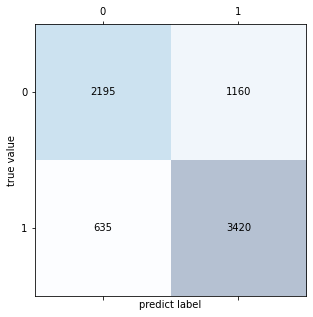

In [72]:
confmat = confusion_matrix(y_test, pred)
fig,ax = plt.subplots(figsize=(5,5))
ax.matshow(confmat,cmap = plt.cm.Blues,alpha = 0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x = j, y = i, s = confmat[i,j],
               va = "center", ha = "center")

plt.xlabel('predict label')
plt.ylabel('true value') 

In [86]:
pos_ind = (pred == 1)


In [85]:
print('True predictive rate:{:.2f}%'.format(np.sum(y_test[pos_ind == 1])/sum(pos_ind)*100))

True predictive rate:74.67%


### Gains and Lift Chart
#### Gain
Gain at a given decile level is the ratio of cumulative number of targets (events) up to that decile to the total number of targets (events) in the entire data set<br>
Interpretation: 
% of targets (events) covered at a given decile level. For example,  80% of targets covered in top 20% of data based on model. In the case of propensity to buy model, we can say we can identify and target 80% of customers who are likely to buy the product by just sending email to 20% of total customers.<br>

#### Lift
It measures how much better one can expect to do with the predictive model comparing without a model. It is the ratio of gain % to the random expectation % at a given decile level. The random expectation at the xth decile is x%.<br>
Interpretation: <br>
The Cum Lift of 4.03 for top two deciles, means that when selecting 20% of the records based on the model, one can expect 4.03 times the total number of targets (events) found by randomly selecting 20%-of-file without a model.


Our model is able to capture 100% churners in the top 20% population

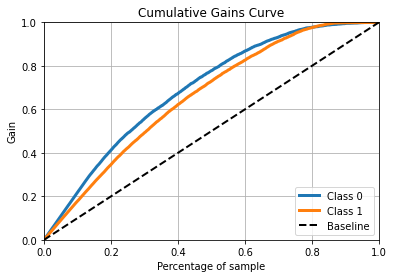

In [87]:
import scikitplot as skplt# Deriving Class probabilities
predicted_probabilities = clf.predict_proba(X_test)# Creating the plot
skplt.metrics.plot_cumulative_gain(y_test, predicted_probabilities)


#### Lift Chart

We are 2.2x times more likely to detect non-churners in the top 20% of the records based on the model than by randomly selecting top 20% records. Lift for churners is 1.8.

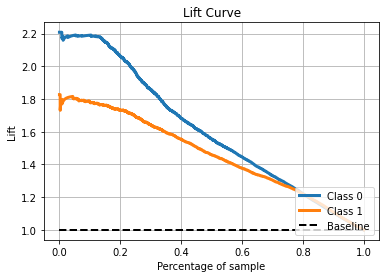

In [88]:
skplt.metrics.plot_lift_curve(y_test, predicted_probabilities)


#### Feature Importance

As explored in the analysis part, my hypothesis is that days_employed and salary will be important metrics in determining churn.

In [89]:
features = x.columns
data = sorted(zip(features,clf.feature_importances_),reverse = True)
data = pd.DataFrame(data,columns = ['feature','importance'])
data = data.sort_values(by = 'importance',ascending = False)

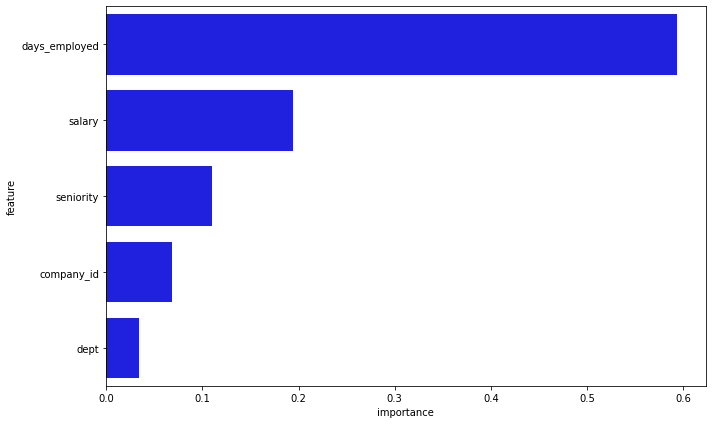

In [90]:
plt.figure(figsize=(10,6))
sns.barplot(x=data['importance'], y=data['feature'], color='blue', orient='h')
plt.tight_layout()

#### Conclusion
1. Length of employment has high impact for predicting churn rate. In particular, employees leave around the end of their first or second year.
2. Increased salary, relative to the department for example in customer service, can reduce churn rate.
3. Using the model, we are 1.8x times more likely to catch "about to churn" employees.